# (16.0) Описание решаемой задачи

В окружении выявленного айсберга необходимо осуществить поиск заявок, которые потенциально могут быть элементами цепочки всплытия айсберга, но при исполнении не были выявлены как айсберг, так как сделка была произведена ровно на объем видимой части. Для полученных результатов осуществить перебор дельт и выбрать наиболее оптимальную для дальнейшего использования

# (16.1) Установка всех необходимых пакетов¶

In [330]:
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt

# (16.2) Определение функций¶

In [156]:
# перевод времени в формат datetime
def ReverseToDateTime(t):
    format = '%Y%m%d%H%M%S%f'
    time_str = dt.datetime.strptime(t,format)
    return time_str

# восстановление стакана заявок и расчет основных метрик
def GlassBuild(for_lob):
    
    #формируем очередь заявок
    
    # устанавливаем маску лимитных заявок заявках (True - лимитная заявка)
    no_mkt_orders = for_lob['PRICE']!=0
    # таблица выставленных заявок
    plc_orders = for_lob[['ORDERNO','BUYSELL','PRICE','VOLUME']][(for_lob ['ACTION']==1) & no_mkt_orders]
    # таблица отмененных заявок
    wdr_orders = for_lob[['ORDERNO','VOLUME']][(for_lob ['ACTION'] == 0) & no_mkt_orders]
    # таблица исполненных заявок
    trd_orders = for_lob [['ORDERNO','VOLUME']][(for_lob['ACTION']==2) & no_mkt_orders]
    trd_orders = trd_orders.groupby(['ORDERNO']).sum()
    trd_orders['ORDERNO'] = trd_orders.index
    trd_orders.index=range(trd_orders.shape[0])
    # собираем все типы заявок в один датафрейм - очередь заявок
    lob_almost = pd.merge(plc_orders,wdr_orders, on='ORDERNO',how='left',suffixes=('_plc','_wdr'))
    lob_almost = pd.merge(lob_almost,trd_orders, on='ORDERNO', how='left')
    lob_almost = lob_almost.rename(columns={'VOLUME':'VOLUME_trd'})
    lob_almost = lob_almost.fillna(0)
    lob_almost['TOTAL_VOL'] = lob_almost['VOLUME_plc'] - lob_almost['VOLUME_wdr'] - lob_almost['VOLUME_trd']
    # удаляем из очереди заявок заявки с нулевым или отрицательным объемом
    lob_almost = lob_almost[['ORDERNO','BUYSELL','PRICE','VOLUME_plc','VOLUME_wdr','VOLUME_trd','TOTAL_VOL']][(lob_almost['TOTAL_VOL']>0)]
    
    # строим стакан
    
    lob = lob_almost.pivot_table(index = "PRICE", columns = "BUYSELL", values = "TOTAL_VOL", aggfunc = 'sum')
    lob.sort_index(axis = 0, inplace = True, ascending = False)
    lob = lob.fillna(0)
    
    # считаем метрики ликвидности
    
    # расчет лучшей цены на покупку
    bid_price = lob[lob['B'] > 0].index[0]
    # расчет объема на уровне лучшей цены на покупку
    bid_volume = lob['B'][bid_price]
    # расчет общего объема на стороне покупки
    bid_depth = lob['B'].sum()
    # расчет объема на уровне 10 лучших цен на стороне покупки
    b_10 = lob[lob['B'] > 0].index[0:10]
    volume_b_10 = 0
    for i in b_10:
        volume_b_10 = volume_b_10 + lob['B'][i]
    # расчет лучшей цены на продажу
    ask_price = lob[lob['S'] > 0].index[-1]
    # расчет объема на уровне лучшей цены на продажу
    ask_volume = lob['S'][ask_price]
    # расчет общего объема на стороне продажи
    ask_depth = lob['S'].sum()
    # расчет объема на уровне 10 лучших цен на стороне продажи
    s_10 = lob[lob['S'] > 0].index[-10:]
    volume_s_10 = 0
    for i in s_10:
        volume_s_10 = volume_s_10 + lob['S'][i]
    
    liquidity = [bid_price, bid_volume, bid_depth, volume_b_10, ask_price, ask_volume, ask_depth, volume_s_10]
     
    return(liquidity)

# проверка, что время выставления каждой следующей заявки в цепочке больше времени исполнения предыдущей, если нет, то такая пара исключается из цепочки
# используется при формировании цепочки перед айсбергом
def ChainPairPrev(list_of_orderno):
    
    list_of_pairs = []
    
    for i in range(len(list_of_orderno)-1):
    
        cur_orderno = list_of_orderno[i]
        prev_orderno = list_of_orderno[i+1]
        cur_time_place_1 = orders_instr.index[(orders_instr.ORDERNO == cur_orderno)&(orders_instr.ACTION == 1)].to_list()[0]
        cur_time_place = orders_instr.loc[cur_time_place_1,'TIME']
        prev_time_trd_1 = orders_instr.index[(orders_instr.ORDERNO == prev_orderno)&(orders_instr.ACTION == 2)].to_list()[-1]
        prev_time_trd = orders_instr.loc[prev_time_trd_1,'TIME']
    
        if (cur_time_place >= prev_time_trd) and ((cur_time_place - prev_time_trd) <= delta):

            list_of_pairs.append([cur_orderno, prev_orderno])
            
        else:
            
            break
    
    list_of_orderno = [orderno]
    
    if len(list_of_pairs) != 0:

        for i in range(len(list_of_pairs)):
    
            list_of_orderno.append(list_of_pairs[i][1])
       
    return(list_of_orderno)

# проверка, что время выставления каждой следующей заявки в цепочке больше времени исполнения предыдущей, если нет, то такая пара исключается из цепочки
# используется при формировании цепочки после айсберга
def ChainPairSuc(list_of_orderno):
    
    list_of_pairs = []
    
    for i in range(len(list_of_orderno)-1):
    
        cur_orderno = list_of_orderno[i]
        suc_orderno = list_of_orderno[i+1]
        cur_time_trd_1 = orders_instr.index[(orders_instr.ORDERNO == cur_orderno)&(orders_instr.ACTION == 2)].to_list()[-1]
        cur_time_trd = orders_instr.loc[cur_time_trd_1,'TIME']
        suc_time_place_1 = orders_instr.index[(orders_instr.ORDERNO == suc_orderno)&(orders_instr.ACTION == 1)].to_list()[0]
        suc_time_place = orders_instr.loc[suc_time_place_1,'TIME']
    
        if (suc_time_place >= cur_time_trd) and ((suc_time_place - cur_time_trd) <= delta):

            list_of_pairs.append([cur_orderno, suc_orderno])
            
        else:
            
            break
    
    list_of_orderno = [orderno]
    
    if len(list_of_pairs) != 0:

        for i in range(len(list_of_pairs)):
    
            list_of_orderno.append(list_of_pairs[i][1])
       
    return(list_of_orderno)

# (16.3) Список всех используемых датафреймов

In [4]:
# orders - ордерлог на заданную дату
# iceberg_all - список всех найденных айсбергов
# orders_instr - ордерлог по инструменту
# ice_instr - список айсбергов по одному инструменту за один день

# (16.4) Определение входных параметров

In [5]:
# создаем список из всех названий файлов с данными (из них в дальнейшем можно извлечь дату)
orderlogs = ['OrderLog20190304.txt',
             'OrderLog20190305.txt',
             'OrderLog20190306.txt',
             'OrderLog20190307.txt',
             'OrderLog20190311.txt',
             'OrderLog20190312.txt',
             'OrderLog20190313.txt',
             'OrderLog20190314.txt',
             'OrderLog20190315.txt',
             'OrderLog20190318.txt',
             'OrderLog20190319.txt',
             'OrderLog20190320.txt',
             'OrderLog20190321.txt',
             'OrderLog20190322.txt',
             'OrderLog20190325.txt',
             'OrderLog20190326.txt',
             'OrderLog20190327.txt',
             'OrderLog20190328.txt',
             'OrderLog20190329.txt'
            ]

In [6]:
# создаем список из инструментов
tickers = ['GAZP',
           'SBER',
           'GMKN',
           'LKOH',
           'MTSS',
           'MGNT',
           'TATN',
           'NVTK',
           'YNDX',
           'ROSN',
           'FIVE',
           'VTBR',
           'SNGS',
           'CHMF',
           'ALRS'
          ]

In [345]:
d = orderlogs[0] 
date = int(d[8:16]) #20190304
ticker = tickers[8] #YNDX
delta = dt.timedelta(microseconds=99000)

# (16.5) Чтение данных

In [9]:
%%time
# преобразуем time в формат datetime
# orders - ордерлог за день
# instr_orders - ордерлог на заданную дату по выбранному инструменту на момет времени t
orders = pd.read_csv(d, header = 0)
orders['together_time'] = str(date)+orders['TIME'].apply(str)
orders['TIME'] = [ReverseToDateTime(orders.together_time[i]) for i in range (len(orders.together_time))]
del orders['together_time']

CPU times: user 5min 33s, sys: 4.28 s, total: 5min 38s
Wall time: 5min 41s


In [346]:
orders_instr = orders[orders.SECCODE == ticker].reset_index()
orders_instr

,index,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE
0,2297,2298,YNDX,S,2019-03-04 10:00:00.000000,2298,1,2315.0,50,NaN,NaN
1,2957,2958,YNDX,S,2019-03-04 10:00:00.000000,2958,1,2300.0,50,NaN,NaN
2,3637,3638,YNDX,S,2019-03-04 10:00:00.000000,3638,1,2298.8,18,NaN,NaN
3,4577,4578,YNDX,S,2019-03-04 10:00:00.000000,4578,1,2449.8,1,NaN,NaN
4,4600,4601,YNDX,S,2019-03-04 10:00:00.000000,4601,1,2399.8,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
129855,5424251,5424252,YNDX,S,2019-03-04 18:44:44.459528,2357504,0,2317.4,5,NaN,NaN
129856,5424260,5424261,YNDX,B,2019-03-04 18:44:48.444374,2565342,0,2231.0,92,NaN,NaN
129857,5424328,5424329,YNDX,B,2019-03-04 18:44:59.238014,2196857,0,2297.6,29,NaN,NaN
129858,5424342,5424343,YNDX,B,2019-03-04 18:44:59.243531,2192515,0,2296.4,25,NaN,NaN


In [14]:
# читаем список выявленных айсберг-заявок + преобразуем время в формат datetime
# iceberg_all - список всех найденных айсбергов
# ice_instr - список айсбергов по одному инструменту за один день
iceberg_all = pd.read_csv('iceberg.csv', header = 0)
iceberg_all['together_time'] = iceberg_all['DATE'].apply(str)+iceberg_all['TIME'].apply(str)
iceberg_all['together_time_identified'] = iceberg_all['DATE'].apply(str)+iceberg_all['TIME_IDENT'].apply(str)
iceberg_all['TIME'] = [ReverseToDateTime(iceberg_all.together_time[i]) for i in range (len(iceberg_all.together_time))]
iceberg_all['TIME_IDENT'] = [ReverseToDateTime(iceberg_all.together_time_identified[i]) for i in range (len(iceberg_all.together_time_identified))]
iceberg_all['DELTA'] = iceberg_all['TIME_IDENT'] - iceberg_all['TIME']
del iceberg_all['together_time']
del iceberg_all['together_time_identified']

In [347]:
ice_instr = iceberg_all[(iceberg_all.SECCODE == ticker) & (iceberg_all.DATE == date)]
ice_instr 

,index,BUYSELL,DATE,ICEBERG,ORDERNO,PRICE,SECCODE,TIME,TIME_IDENT,VOLUME,VOLUME_INI,DELTA
1499,0,B,20190304,1,44873,2260.2,YNDX,2019-03-04 10:00:02.441149,2019-03-04 10:00:31.867019,-49,100,00:00:29.425870
1500,1,B,20190304,1,59940,2260.2,YNDX,2019-03-04 10:00:31.867909,2019-03-04 10:00:31.872831,-23,51,00:00:00.004922
1501,2,B,20190304,1,360664,2265.0,YNDX,2019-03-04 10:30:36.818060,2019-03-04 10:30:36.818060,-1155,100,00:00:00
1502,3,S,20190304,1,371288,2264.6,YNDX,2019-03-04 10:32:30.339212,2019-03-04 10:32:33.868510,-107,100,00:00:03.529298
1503,4,S,20190304,1,377811,2264.6,YNDX,2019-03-04 10:33:35.808873,2019-03-04 10:33:49.123418,-2,100,00:00:13.314545
1504,5,S,20190304,1,379700,2264.6,YNDX,2019-03-04 10:33:49.126256,2019-03-04 10:33:51.803463,-303,98,00:00:02.677207
1505,6,S,20190304,1,380294,2264.6,YNDX,2019-03-04 10:33:51.816989,2019-03-04 10:36:59.278348,-13,97,00:03:07.461359
1506,7,S,20190304,1,398006,2264.6,YNDX,2019-03-04 10:36:59.289970,2019-03-04 10:38:05.451334,-32,87,00:01:06.161364
1507,8,S,20190304,1,404111,2264.6,YNDX,2019-03-04 10:38:05.451668,2019-03-04 10:44:32.062622,-18,68,00:06:26.610954
1508,9,B,20190304,1,410089,2263.6,YNDX,2019-03-04 10:39:03.709069,2019-03-04 10:39:03.709069,-131,100,00:00:00


# (16.6) Выбираем айсберг для анализа

In [333]:
# вводим индекс айсберга из списка его окружения и извлекаем основную информацию из него
id = 1778
test = ice_instr.loc[id]
buysell = ice_instr.loc[id][1]
date = ice_instr.loc[id][2]
orderno = ice_instr.loc[id][4]
price = ice_instr.loc[id][5]
ticker = ice_instr.loc[id][6]
time_place = ice_instr.loc[id][7]
time_ident = ice_instr.loc[id][8]
volume_ini = ice_instr.loc[id][10]

test

index                                 36
BUYSELL                                S
DATE                            20190304
ICEBERG                                1
ORDERNO                          1118463
PRICE                              94.11
SECCODE                             ALRS
TIME          2019-03-04 12:48:45.006040
TIME_IDENT    2019-03-04 12:48:45.045541
VOLUME                             -1370
VOLUME_INI                          1500
DELTA             0 days 00:00:00.039501
Name: 1778, dtype: object

# (16.7) Анализ интервала перед выставлением айсберга для поиска потенциальных элементов микроцепочки

Предполагается, что найденный айсберг - это элемент цепочки всплытия айсберга и перед ним была исполнена как минимум одна заявка на объем видимой части, которая и инициировала всплытие айсберга. Поиск таких заявок необходимо осуществлять поиск заявок, удовлетворяющих следующим условиям:
1. orders_instr.ORDERNO < orderno  
2. orders_instr.PRICE == price
3. orders_instr.BUYSELL == buysell
4. время выставления следующей заявки находится в допустимом интервале после исполнения предыдущей
5. объем выставленной заявки == объему исполнения (НО! надо найти заявку с ACTION = 1 для этого)

In [334]:
%%time

ice_index = orders_instr.index[(orders_instr.ORDERNO == orderno)&(orders_instr.ACTION == 1)&(orders_instr.TIME == time_place)].to_list()[0]
cur_price = orders_instr.loc[ice_index,'PRICE']

'''for i in range(ice_index):
        
        cur_index = ice_index - i
        for_lob = orders_instr[orders_instr.index <= cur_index]

        if buysell == 'B':
            
            if GlassBuild(for_lob)[0] < cur_price:

                left_border = orders_instr.loc[cur_index,'TIME']
                left_index = cur_index
                
                break

        elif buysell == 'S':
            
            if GlassBuild(for_lob)[4] > cur_price:
                
                left_border = orders_instr.loc[cur_index,'TIME']
                left_index = cur_index
                 
                break
print(left_border)'''

'''if left_border >= (time_place - delta):
    
    left_border = (time_place - delta)'''

left_border = ReverseToDateTime('20190304100000000000')

# отбираем все заявки с параметрами айсберга (кроме объема), сделки по которым произошли в заданном интервале
# test - список всех заявок с параматерами айсберга (кроме объема), сделки по которым произошли в заданном интервале
test = orders_instr[((orders_instr.BUYSELL == buysell) & 
             (orders_instr.PRICE == price) & 
             (orders_instr.TIME >= left_border)& 
             (orders_instr.TIME <= time_ident)&
             (orders_instr.ORDERNO < orderno)&
             (orders_instr.ACTION == 2)     
            )]['ORDERNO'].unique().tolist()

# проверяем, что исходный объем найденных заявок совпадает с видимой частью айсберга
# test1 - список всех заявок с параматерами айсберга, сделки по которым произошли в заданном интервале
test1 = []

for i in test:
    
    trade_orderno = i
    order_volume = orders_instr.loc[(orders_instr.ORDERNO == trade_orderno) & (orders_instr.ACTION == 1)]['VOLUME'].values[0]
    
    if order_volume == volume_ini:
        
        test1.append(i)

# дописываем номер айсберг заявки в найденную цепочку
test1.append(orderno)
# разворачиваем список заявок от самой новой до самой старой
test1 = test1[::-1]

# проверяем, что время между выставлениями заявок в цепочке меньше, чем заданная ранее дельта и создаем список из заявок, которые удовлетворяют этому условию
chain_prev = ChainPairPrev(test1)
chain_prev

CPU times: user 114 ms, sys: 28.1 ms, total: 142 ms
Wall time: 157 ms


[1118463, 1118452, 1118245, 1118242, 1118237]

In [45]:
orders_instr[orders_instr['ORDERNO'].isin (chain_prev)]

,index,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE
315172,4952800,4952801,GAZP,B,2019-03-04 18:02:40.779646,2391293,1,155.0,1000,NaN,NaN
315173,4952801,4952802,GAZP,B,2019-03-04 18:02:40.779646,2391293,2,155.0,360,2.936006e+09,155.0
315176,4952810,4952811,GAZP,B,2019-03-04 18:02:40.780238,2391293,2,155.0,280,2.936006e+09,155.0
315179,4952814,4952815,GAZP,B,2019-03-04 18:02:40.780979,2391293,2,155.0,80,2.936006e+09,155.0
315182,4952817,4952818,GAZP,B,2019-03-04 18:02:40.781547,2391293,2,155.0,200,2.936006e+09,155.0
315186,4952934,4952935,GAZP,B,2019-03-04 18:02:41.562406,2391293,2,155.0,1530,2.936006e+09,155.0
315211,4953109,4953110,GAZP,B,2019-03-04 18:02:41.620190,2391423,1,155.0,1000,NaN,NaN
315215,4953114,4953115,GAZP,B,2019-03-04 18:02:41.621290,2391423,2,155.0,600,2.936006e+09,155.0
315219,4953120,4953121,GAZP,B,2019-03-04 18:02:41.631653,2391423,2,155.0,1600,2.936006e+09,155.0
315227,4953128,4953129,GAZP,B,2019-03-04 18:02:41.632828,2391433,1,155.0,1000,NaN,NaN


# (16.5) Анализ интервала после вскрытия айсберга для поиска потенциальных элементов микроцепочки



In [335]:
%%time
right_border = ReverseToDateTime('20190304184500000000')

# отбираем все заявки с параметрами айсберга (кроме объема), сделки по которым произошли в заданном интервале
# train - список всех заявок с параматерами айсберга (кроме объема), сделки по которым произошли в заданном интервале
train = orders_instr[((orders_instr.BUYSELL == buysell) & 
             (orders_instr.PRICE == price) & 
             (orders_instr.TIME >= time_ident)& 
             (orders_instr.TIME <= right_border)&
             (orders_instr.ORDERNO > orderno)&
             (orders_instr.ACTION == 1)     
            )]['ORDERNO'].unique().tolist()

# проверяем, что исходный объем найденных заявок совпадает с видимой частью айсберга + проверяем, что по всем найденным заявкам была сделка
# train1 - список всех заявок с параматерами айсберга, сделки по которым произошли в заданном интервале
train1 = [orderno]

for i in train:
    
    trade_orderno = i
    order_volume = orders_instr.loc[(orders_instr.ORDERNO == trade_orderno) & (orders_instr.ACTION == 1)]['VOLUME'].values[0]
    trade_volume = orders_instr.loc[(orders_instr.ORDERNO == trade_orderno) & (orders_instr.ACTION == 2)]['VOLUME'].sum()
    
    if (order_volume == volume_ini) and (order_volume <= trade_volume):
        
        train1.append(i)
        
# проверяем, что время между выставлениями заявок в цепочке меньше, чем заданная ранее дельта и создаем список из заявок, которые удовлетворяют этому условию
chain_suc = ChainPairSuc(train1)
chain_suc

CPU times: user 1.04 s, sys: 18.7 ms, total: 1.05 s
Wall time: 1.09 s


[1118463]

In [115]:
orders_instr[orders_instr['ORDERNO'].isin (chain_suc)]

,index,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE
315288,4953515,4953516,GAZP,B,2019-03-04 18:02:41.726467,2391577,1,155.0,1000,NaN,NaN
315295,4953583,4953584,GAZP,B,2019-03-04 18:02:41.754006,2391577,2,155.0,590,2.936006e+09,155.0
315298,4953598,4953599,GAZP,B,2019-03-04 18:02:41.756361,2391577,2,155.0,1600,2.936006e+09,155.0


# (16.6) Объединяем цепочки

Объединяем цепочку до с цепочкой после. Заносим информацию по цепочке (ордерно первого элемента chain) в ice_instr.chain_id  всех найденных айсбергов 
Добавить в цикл условие, что анализ цепочек проводится только для тех айсбергов, у которых пустой ice_instr.chain_id

In [336]:
# объединяем цепочку до с цепочкой после
chain = chain_prev[::-1] + chain_suc[1:len(chain_suc)]
chain

[1118237, 1118242, 1118245, 1118452, 1118463]

In [117]:
orders_instr[orders_instr['ORDERNO'].isin (chain)]

,index,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE
315172,4952800,4952801,GAZP,B,2019-03-04 18:02:40.779646,2391293,1,155.0,1000,NaN,NaN
315173,4952801,4952802,GAZP,B,2019-03-04 18:02:40.779646,2391293,2,155.0,360,2.936006e+09,155.0
315176,4952810,4952811,GAZP,B,2019-03-04 18:02:40.780238,2391293,2,155.0,280,2.936006e+09,155.0
315179,4952814,4952815,GAZP,B,2019-03-04 18:02:40.780979,2391293,2,155.0,80,2.936006e+09,155.0
315182,4952817,4952818,GAZP,B,2019-03-04 18:02:40.781547,2391293,2,155.0,200,2.936006e+09,155.0
315186,4952934,4952935,GAZP,B,2019-03-04 18:02:41.562406,2391293,2,155.0,1530,2.936006e+09,155.0
315211,4953109,4953110,GAZP,B,2019-03-04 18:02:41.620190,2391423,1,155.0,1000,NaN,NaN
315215,4953114,4953115,GAZP,B,2019-03-04 18:02:41.621290,2391423,2,155.0,600,2.936006e+09,155.0
315219,4953120,4953121,GAZP,B,2019-03-04 18:02:41.631653,2391423,2,155.0,1600,2.936006e+09,155.0
315227,4953128,4953129,GAZP,B,2019-03-04 18:02:41.632828,2391433,1,155.0,1000,NaN,NaN


In [118]:
# определяем индекс всех айсбергов, которые вошли в цепочку и меняем их chain_id
ices = ice_instr.index[ice_instr['ORDERNO'].isin(chain)].to_list()

for i in ices:
    
    ice_instr.loc[i, 'CHAIN_ID'] = chain[0]

In [332]:
t = [1118237, 1118242, 1118245, 1118452, 1118463]
ice_instr[ice_instr['ORDERNO'].isin (t)]

,index,BUYSELL,DATE,ICEBERG,ORDERNO,PRICE,SECCODE,TIME,TIME_IDENT,VOLUME,VOLUME_INI,DELTA
1778,36,S,20190304,1,1118463,94.11,ALRS,2019-03-04 12:48:45.006040,2019-03-04 12:48:45.045541,-1370,1500,00:00:00.039501


# (16.7) Создаем цикл, в котором для разных дельт будет считаться длина цепочек одного и того же айсберга

In [265]:
d = orderlogs[0] 
date = int(d[8:16]) #20190304
ticker = tickers[11] #SBER
delta = dt.timedelta(microseconds=99000)

In [266]:
orders_instr = orders[orders.SECCODE == ticker].reset_index()
ice_instr = iceberg_all[(iceberg_all.SECCODE == ticker) & (iceberg_all.DATE == date)]

In [268]:
ice_instr

,index,BUYSELL,DATE,ICEBERG,ORDERNO,PRICE,SECCODE,TIME,TIME_IDENT,VOLUME,VOLUME_INI,DELTA
1571,0,S,20190304,1,210565,0.036095,VTBR,2019-03-04 10:07:44.042531,2019-03-04 10:07:44.492423,-2000000,1000000,00:00:00.449892
1572,1,S,20190304,1,562290,0.036090,VTBR,2019-03-04 11:06:25.856876,2019-03-04 11:07:56.489665,-6500000,1000000,00:01:30.632789
1573,2,S,20190304,1,983334,0.036120,VTBR,2019-03-04 12:22:03.901721,2019-03-04 12:22:03.901721,-410000,1000000,00:00:00
1574,3,S,20190304,1,983338,0.036120,VTBR,2019-03-04 12:22:03.904343,2019-03-04 12:22:04.062148,-790000,590000,00:00:00.157805
1575,4,S,20190304,1,983356,0.036120,VTBR,2019-03-04 12:22:04.219866,2019-03-04 12:23:05.287500,-1250000,210000,00:01:01.067634
1576,5,S,20190304,1,987072,0.036120,VTBR,2019-03-04 12:23:05.288663,2019-03-04 12:24:20.205902,-970000,750000,00:01:14.917239
1577,6,S,20190304,1,991669,0.036120,VTBR,2019-03-04 12:24:20.216957,2019-03-04 12:25:20.211152,-240000,30000,00:00:59.994195
1578,7,S,20190304,1,1004697,0.036080,VTBR,2019-03-04 12:26:48.916958,2019-03-04 12:26:48.916958,-2550000,1000000,00:00:00
1579,8,S,20190304,1,1004698,0.036080,VTBR,2019-03-04 12:26:48.916958,2019-03-04 12:26:48.916958,-30000,450000,00:00:00
1580,9,S,20190304,1,1004699,0.036080,VTBR,2019-03-04 12:26:48.916958,2019-03-04 12:26:48.916958,-2540000,970000,00:00:00


In [267]:
orders_instr

,index,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE
0,326,327,VTBR,S,2019-03-04 10:00:00.000000,327,1,0.039045,10000,NaN,NaN
1,346,347,VTBR,B,2019-03-04 10:00:00.000000,347,1,0.032850,10000,NaN,NaN
2,363,364,VTBR,S,2019-03-04 10:00:00.000000,364,1,0.036300,10000,NaN,NaN
3,523,524,VTBR,B,2019-03-04 10:00:00.000000,524,1,0.034265,100000,NaN,NaN
4,852,853,VTBR,B,2019-03-04 10:00:00.000000,853,1,0.035100,160000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
130260,5424021,5424022,VTBR,S,2019-03-04 18:43:25.066411,2583125,0,0.036030,10000000,NaN,NaN
130261,5424077,5424078,VTBR,B,2019-03-04 18:43:41.898698,2458385,0,0.035870,2000000,NaN,NaN
130262,5424142,5424143,VTBR,B,2019-03-04 18:44:07.621960,2346176,0,0.035195,20000000,NaN,NaN
130263,5424169,5424170,VTBR,S,2019-03-04 18:44:13.393783,2227849,0,0.036110,2850000,NaN,NaN


In [348]:
# выбираем айсберг для анализа
id = 1503
test = ice_instr.loc[id]
buysell = ice_instr.loc[id][1]
date = ice_instr.loc[id][2]
orderno = ice_instr.loc[id][4]
price = ice_instr.loc[id][5]
ticker = ice_instr.loc[id][6]
time_place = ice_instr.loc[id][7]
time_ident = ice_instr.loc[id][8]
volume_ini = ice_instr.loc[id][10]

test

index                                  4
BUYSELL                                S
DATE                            20190304
ICEBERG                                1
ORDERNO                           377811
PRICE                             2264.6
SECCODE                             YNDX
TIME          2019-03-04 10:33:35.808873
TIME_IDENT    2019-03-04 10:33:49.123418
VOLUME                                -2
VOLUME_INI                           100
DELTA             0 days 00:00:13.314545
Name: 1503, dtype: object

In [349]:
sum = 10000
delta_list = [sum]

while sum <= 999000:
    
    sum = sum + 10000
    delta_list.append(sum)

In [350]:
%%time
results = []

for j in delta_list:
    
    delta = dt.timedelta(microseconds=j)
    ice_index = orders_instr.index[(orders_instr.ORDERNO == orderno)&(orders_instr.ACTION == 1)&(orders_instr.TIME == time_place)].to_list()[0]
    cur_price = orders_instr.loc[ice_index,'PRICE']


    left_border = ReverseToDateTime('20190304100000000000')

    # отбираем все заявки с параметрами айсберга (кроме объема), сделки по которым произошли в заданном интервале
    # test - список всех заявок с параматерами айсберга (кроме объема), сделки по которым произошли в заданном интервале
    test = orders_instr[((orders_instr.BUYSELL == buysell) & 
                 (orders_instr.PRICE == price) & 
                 (orders_instr.TIME >= left_border)& 
                 (orders_instr.TIME <= time_ident)&
                 (orders_instr.ORDERNO < orderno)&
                 (orders_instr.ACTION == 2)     
                )]['ORDERNO'].unique().tolist()

    # проверяем, что исходный объем найденных заявок совпадает с видимой частью айсберга
    # test1 - список всех заявок с параматерами айсберга, сделки по которым произошли в заданном интервале
    test1 = []

    for i in test:

        trade_orderno = i
        order_volume = orders_instr.loc[(orders_instr.ORDERNO == trade_orderno) & (orders_instr.ACTION == 1)]['VOLUME'].values[0]

        if order_volume == volume_ini:

            test1.append(i)

    # дописываем номер айсберг заявки в найденную цепочку
    test1.append(orderno)
    # разворачиваем список заявок от самой новой до самой старой
    test1 = test1[::-1]

    # проверяем, что время между выставлениями заявок в цепочке меньше, чем заданная ранее дельта и создаем список из заявок, которые удовлетворяют этому условию
    chain_prev = ChainPairPrev(test1)

    right_border = ReverseToDateTime('20190304184500000000')

    # отбираем все заявки с параметрами айсберга (кроме объема), сделки по которым произошли в заданном интервале
    # train - список всех заявок с параматерами айсберга (кроме объема), сделки по которым произошли в заданном интервале
    train = orders_instr[((orders_instr.BUYSELL == buysell) & 
                 (orders_instr.PRICE == price) & 
                 (orders_instr.TIME >= time_ident)& 
                 (orders_instr.TIME <= right_border)&
                 (orders_instr.ORDERNO > orderno)&
                 (orders_instr.ACTION == 1)     
                )]['ORDERNO'].unique().tolist()

    # проверяем, что исходный объем найденных заявок совпадает с видимой частью айсберга + проверяем, что по всем найденным заявкам была сделка
    # train1 - список всех заявок с параматерами айсберга, сделки по которым произошли в заданном интервале
    train1 = [orderno]

    for i in train:

        trade_orderno = i
        order_volume = orders_instr.loc[(orders_instr.ORDERNO == trade_orderno) & (orders_instr.ACTION == 1)]['VOLUME'].values[0]
        trade_volume = orders_instr.loc[(orders_instr.ORDERNO == trade_orderno) & (orders_instr.ACTION == 2)]['VOLUME'].sum()

        if (order_volume == volume_ini) and (order_volume <= trade_volume):

            train1.append(i)

    # проверяем, что время между выставлениями заявок в цепочке меньше, чем заданная ранее дельта и создаем список из заявок, которые удовлетворяют этому условию
    chain_suc = ChainPairSuc(train1)
    chain_suc

    # проверяем, что время между выставлениями заявок в цепочке меньше, чем заданная ранее дельта и создаем список из заявок, которые удовлетворяют этому условию
    chain_suc = ChainPairSuc(train1)
    
    chain = chain_prev[::-1] + chain_suc[1:len(chain_suc)]
    
    results.append([j, len(chain)])

CPU times: user 18.6 s, sys: 381 ms, total: 19 s
Wall time: 20.1 s


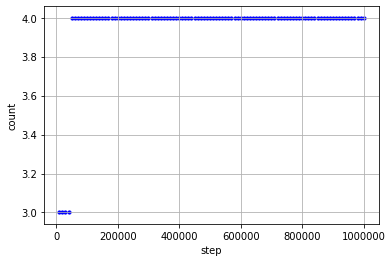

In [354]:
step = []
count = []

for i in range(len(results)):
    
    step.append(results[i][0])
    count.append(results[i][1])
    
df1 = pd.DataFrame({'step':pd.Series(step),
     'count': pd.Series(count)})

df1.plot.scatter(x='step', y='count', s=10, color='blue', grid=True)